# Cropland extent maps for Africa

* **Products used:** 
[crop_mask](https://explorer.digitalearth.africa/crop_mask)

### Background

A central focus for governing bodies in Africa is the need to secure the necessary food sources to support their populations. It has been estimated that the current production of crops will need to double by 2050 to meet future needs for food production. Higher level crop-based products that can assist with managing food insecurity, such as cropping watering intensities, crop types, or crop productivity, require as a starting point precise and accurate cropland extent maps indicating where cropland occurs. Current cropland extent maps are either inaccurate, have coarse spatial resolutions, or are not updated regularly. An accurate, high-resolution, and regularly updated cropland area map for the African continent is therefore recognised as a gap in the current crop monitoring services.

Digital Earth Africa's cropland extent maps for Africa show the estimated location of croplands for the period of January to Decemeber 2019.

For a full description of the product specifications, validation results, and methods used to develop the products, see the [Cropland_extent_specifications](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) document. 

## Description

This notebook will show you how to load, plot, and conduct a simple analysis using the cropland extent product. The steps are as follows:
 
1. List the available cropland extent products
2. Load the `crop_mask` product
3. Plotting the different measurements of the crop-mask
4. Example analysis 1: Identifying crop trends with NDVI
5. Example analysis 2: Comparison of cropped area with global land cover datasets
6. Inspect different regions of the crop mask.

For a more detailed example of using the cropland extent product, see the following notebooks:

* [Cropland vegetation anomalies](../Real_world_examples/Vegetation_anomalies_monthly.ipynb)
* [Phenology_optical](../Real_world_examples/Phenology_optical.ipynb)
* [Phenology_radar](../Real_world_examples/Phenology_radar.ipynb)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.plotting import display_map
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='cropland_extent')

### Analysis parameters

This section defines the analysis parameters, including:

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `time_period`: time period to load for the crop mask.  Currently, only a map for 2019 is available
* `resolution`: the pixel resolution to use for loading the `crop_mask_<region>`. The native resolution of the product is 10 metres i.e. `(-10,10)`

The default location is in a extensivley cultivated valley north of Addis Ababa, Ethiopia

In [3]:
lat, lon = 8.5615, 40.691

buffer = 0.04

time_period = ('2019')

resolution=(-10, 10)

#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(lon_range, lat_range)

## List cropland extent products available in Digital Earth Africa

We can use datacube's `list_measurements` functionality to inspect the cropland extent products available in the datacube. The table below shows the product names you can use to load data, and the measurements available for each product. The cropland extent masks come with three measurements: `mask`, `filtered`, and `prob`.

We can see in the table below that there is a single `crop_mask` product which covers the entire continent. It is comprised of numerous `crop_mask_<region>` products stitched together. We can use the continental `crop_mask` products for most applications, though we should be aware of the boundaries of the regional products that comprise it. We will explore this further below.

In [5]:
dc_measurements = dc.list_measurements()
dc_measurements.filter(like='crop_mask', axis=0)

name  dtype units  nodata  \
product                measurement                                  
crop_mask              mask             mask  uint8     1   255.0   
                       prob             prob  uint8     1   255.0   
                       filtered     filtered  uint8     1   255.0   
crop_mask_central      mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_eastern      mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_indian_ocean mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_northern     mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_sahel        mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_southeast    mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_southern     mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   
crop_mask_western      mask             mask  uint8     1     0.0   
                       prob             prob  uint8     1     0.0   
                       filtered     filtered  uint8     1     0.0   

                                              aliases flags_definition  
product                measurement                                      
crop_mask              mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_central      mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_eastern      mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_indian_ocean mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_northern     mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_sahel        mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_southeast    mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_southern     mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              NaN  
                       filtered                [mode]              NaN  
crop_mask_western      mask         [crop_mask, MASK]              NaN  
                       prob         [crop_prob, PROB]              

## Loading the cropland extent product

In this example, we will load the `'crop_mask'` product.


In [6]:
# generate a query object from the analysis parameters
query = {
    'time': time_period,
    'x': lon_range,
    'y': lat_range,
    'resolution':resolution
}

# now load the crop-mask using the query
cm = dc.load(product='crop_mask',
             **query).squeeze()
print(cm)

<xarray.Dataset>
Dimensions:      (y: 1011, x: 773)
Coordinates:
    time         datetime64[ns] 2019-07-02T11:59:59.999999
  * y            (y) float64 1.093e+06 1.093e+06 ... 1.083e+06 1.083e+06
  * x            (x) float64 3.922e+06 3.922e+06 3.922e+06 ... 3.93e+06 3.93e+06
    spatial_ref  int32 6933
Data variables:
    mask         (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    prob         (y, x) uint8 41 41 41 45 43 45 40 36 ... 14 17 18 24 22 23 22
    filtered     (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Plotting the cropland extent

Above, we can see the `crop_mask` products contains three measurements:

   * `mask`: This band displays cropped regions as a binary map. Values of `1` indicate the presence of crops, while a value of `0` indicates the absence of cropping. This band is a _pixel-based_ cropland extent map, meaning the map displays the raw output of the pixel-based Random Forest classification.
   
   * `prob`: This band displays the prediction probabilities for the 'crop' class. As this service uses a random forest classifier, the prediction probabilities refer to the percentage of trees that voted for the random forest classification. For example, if the model had 200 decision trees in the random forest, and 150 of the trees voted 'crop', the prediction probability is **150 / 200 x 100 = 75 %**. Thresholding this band at > 50 % will produce a map identical to `mask`. 
   
   * `filtered`: This band displays cropped regions as a binary map. Values of `1` indicate the presence of crops, while a value of `0` indicates the absence of cropping. This band is an _object-based_ cropland extent map where the `mask` band has been filtered using an image segmentation algorithm (see [this paper](https://www.mdpi.com/2072-4292/6/7/6111/htm) for details on the algorithm used). During this process, segments smaller than 1 Ha (100 10m x 10m pixels) are merged with neighbouring segments, resulting in a map where the smallest classified region is 1 Ha in size. The `filtered` dataset is provided as a complement to the `mask` band; small commission errors are removed by object-based filtering, and the 'salt and pepper' effect typical of classifying pixels is diminished.  
   
Below, we will plot the three measurements side-by-side:

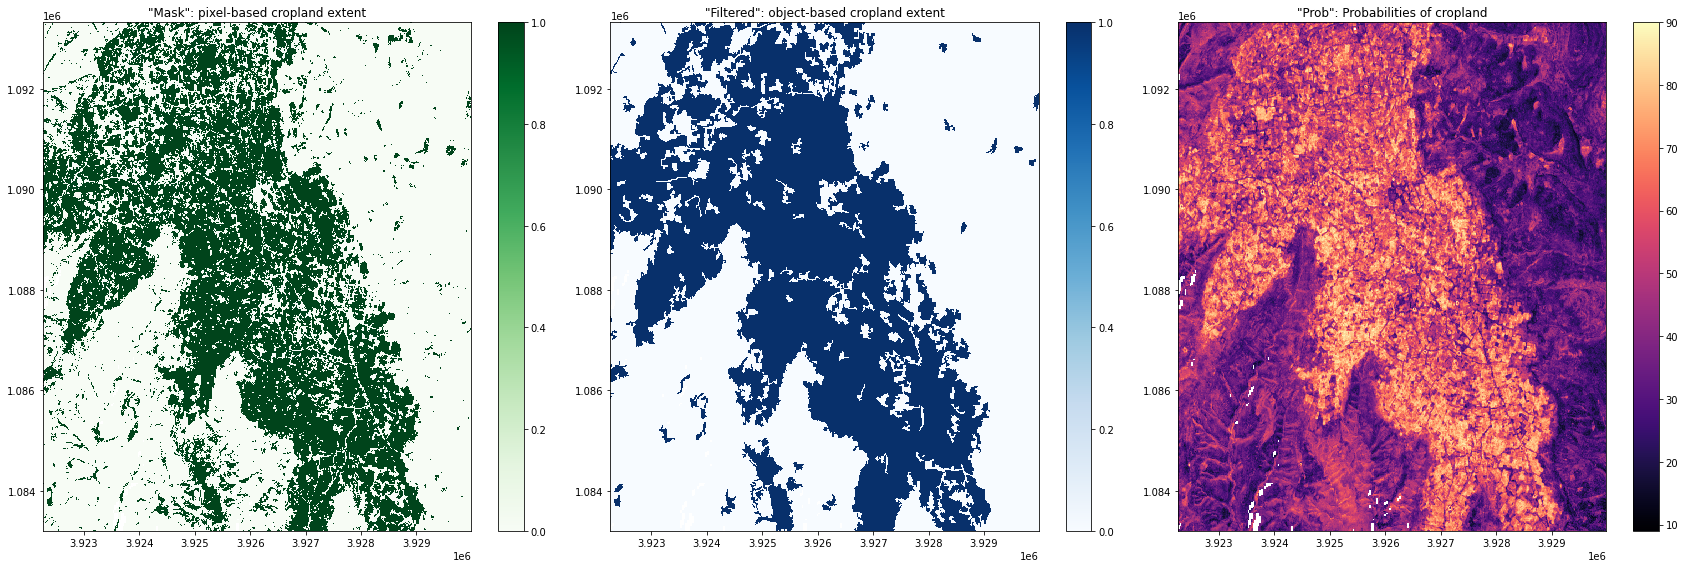

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
cm.mask.where(cm.mask<255).plot(ax=axes[0], # we filter to <255 to omit missing data
                   cmap='Greens', 
                   add_labels=False)

cm.filtered.where(cm.filtered<255).plot(ax=axes[1], 
                   cmap='Blues', 
                   add_labels=False)

cm.prob.where(cm.prob<255).plot(ax=axes[2], 
                   cmap='magma', 
                   add_labels=False)

axes[0].set_title('"Mask": pixel-based cropland extent')
axes[1].set_title('"Filtered": object-based cropland extent')
axes[2].set_title('"Prob": Probabilities of cropland');

plt.tight_layout();

## Example application: Identifying crop trends with NDVI

The Normalised Difference Vegetation Index (NDVI) can be used to track the health and growth of crops as they mature. Here will load an annual time series of Sentinel-2 satellite data, calculate the NDVI, and mask the region with DE Africa's cropland extent product.  With only the cropping pixels remaining, we can summarise the growth cycle of the crops within the region. 

In [8]:
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              time=('2019-01', '2019-12'), 
              measurements=['red', 'nir'],
              mask_filters=(['opening',5],['closing', 5]), #improve cloud mask
              min_gooddata=0.35,
              like=cm.geobox
             )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 114 out of 145 time steps with at least 35.0% good quality pixels
Applying morphological filters to pq mask (['opening', 5], ['closing', 5])
Applying pixel quality/cloud mask
Loading 114 time steps


### Calculate NDVI

In [9]:
ds = calculate_indices(ds, 'NDVI', drop=True, satellite_mission='s2')

Dropping bands ['red', 'nir']


### Resample the dataset to monthly time-steps

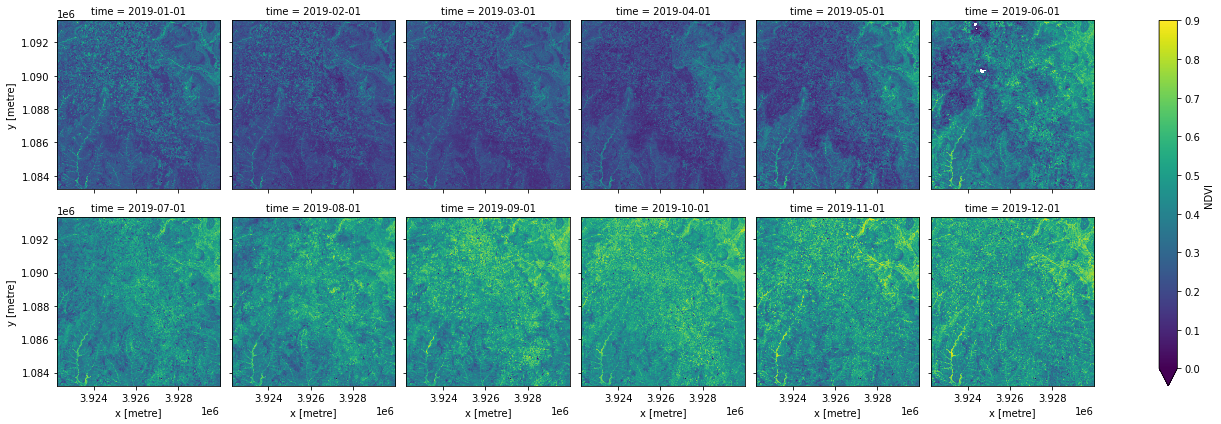

In [10]:
ds = ds.NDVI.resample(time='MS').mean()

#plot the result
ds.plot.imshow(col='time', col_wrap=6, vmin=0, vmax=0.9);

### Mask with the cropland extent map

Using the measurement `filtered`, we can mask the dataset with the `crop_mask` product.

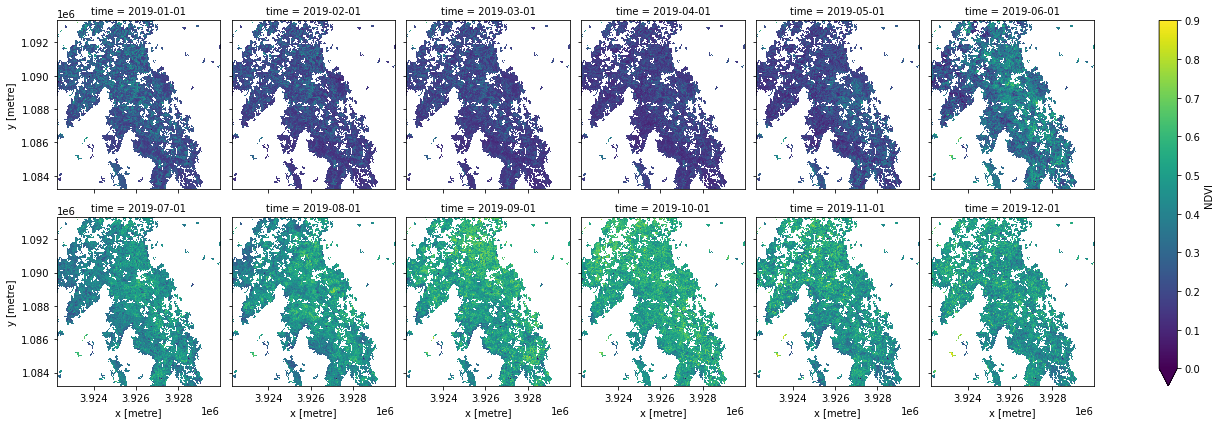

In [11]:
#Filter out the no-data pixels (255) and non-crop pixels (0) from the crop-mask 'filtered' band and
#mask using 'filtered' band.
ds = ds.where(cm.filtered == 1)

ds.plot.imshow(col='time', col_wrap=6, vmin=0, vmax=0.9);

### Summarise the trends in NDVI for the croppping regions with a line plot

Below, the plot shows the cropping schedule starts in April, with the peak of the growing season occuring towards the end of the year in October/November.

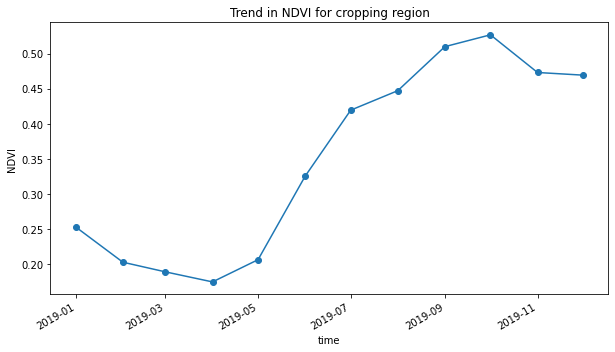

In [12]:
ds.mean(['x', 'y']).plot.line(marker='o', figsize=(10,5))
plt.title('Trend in NDVI for cropping region');

## Example Analysis 2: Comparison with global landcover datasets

Indexed within the DE Africa's datacube are two global 10m resolution landcover datasets that each contain a cropping class. These landcover datasets were both produced using Senitnel-2 images, the same as DE Afric's cropland extent product.  Below, we will load the landcover datasets over the same region as the cropland extent map and compare the area classified as croppping.  You can use the interactive map plotted below to determine the areas where each datasets does well (or poorly) at classifying crops.    

To learn more about the landcover datasets see the [Landcover Classification](Landcover_Classification.ipynb) notebook.

First, we need to re-enter some analysis parameters. You'll notice below we've set the resolution to 60m to allow us to load a large region quickly, though all datasets are natively stored at 10m resolution.

The default region is a bounding box over Lake Kyoga, Uganda. This region is extensively cropped.

In [13]:
lat, lon = 1.4315, 33.1207

buffer = 1.0

resolution=(-60, 60) #resample to load larger area

#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

### Plot an interactive map

If you zoom in you can examine the dominant land cover classes in the region (hint, there's a lot of agriculture!)

In [14]:
display_map(lon_range, lat_range)

### Load the cropland extent, ESRI's Landcover product, and ESA's WorldCover product

In [15]:
# generate a query object from the analysis parameters
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution':resolution
}

# now load the crop-mask using the query
cm = dc.load(product='crop_mask', measurements=['mask'], **query, time='2019').squeeze()

#load the two landcover datasets for the year 2020.
lulc_esa = dc.load(product='esa_worldcover', time="2020", measurements='classification', like=cm.geobox).squeeze()
lulc_esri = dc.load(product='io_lulc', time="2020-07", measurements='classification', like=cm.geobox).squeeze()

Reclassify the landcover datasets to a binary crop/non-crop image to allow a straightforward comparison with DE Africa's cropland extent map

In [16]:
esri_crops = xr.where(lulc_esri['classification']==5, 1, 0)
esa_crops = xr.where(lulc_esa['classification']==40, 1, 0)

Filter out the no-data pixels (255) from the crop-mask `mask` band.

In [17]:
cm_mask = cm.mask.where(cm.mask != 255)

### Plot the cropping extent of the three datasets

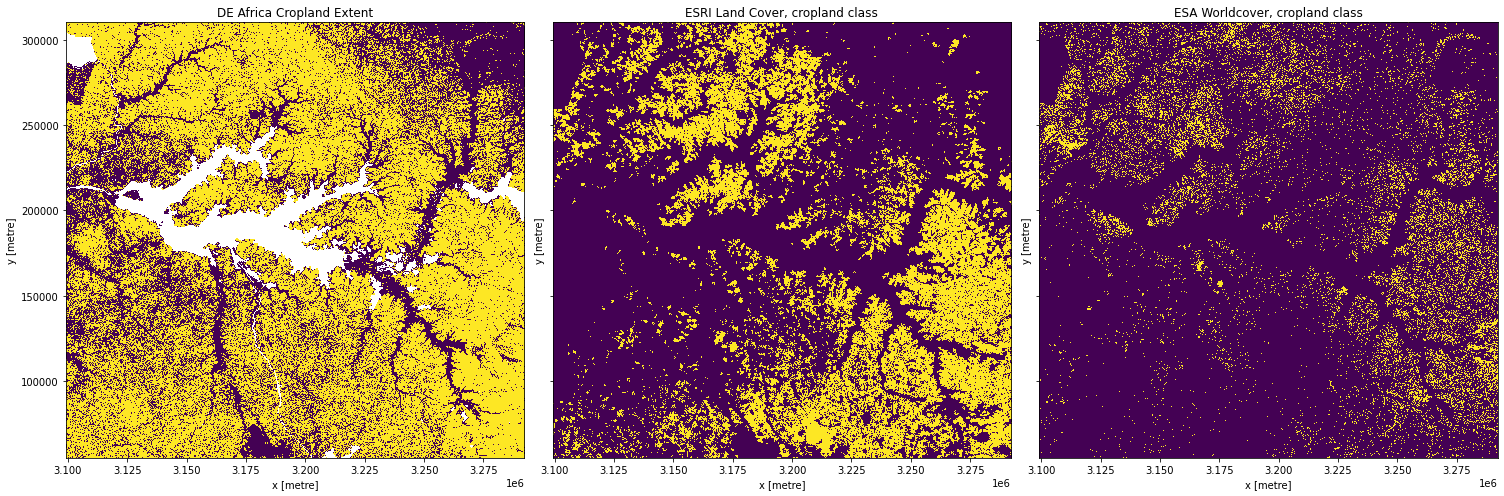

In [18]:
fig,ax=plt.subplots(1,3, sharey=True, figsize=(21,7))
cm_mask.plot.imshow(ax=ax[0], add_colorbar=False)
esri_crops.plot.imshow(ax=ax[1], add_colorbar=False)
esa_crops.plot.imshow(ax=ax[2], add_colorbar=False)
ax[0].set_title('DE Africa Cropland Extent')
ax[1].set_title('ESRI Land Cover, cropland class')
ax[2].set_title('ESA Worldcover, cropland class')
plt.tight_layout();

### Calculate the cropped area in each product

In this example, you'll see that DE Africa's cropland product maps a lot more cropping than the two global landcover products.  In this example, the DE Africa product is more accurate than the landcover datasets. However, over wetlands in the south-west of Lake Kyoga DE Afria's product incorrectly maps some of the wetlands as cropping, while the landcover datasets do not.  While there are regions where DE AFrica's cropland extent maps have errors, in general they are much more accurate than any of the currently existing landcover datasets over Africa.

In [19]:
pixel_length = query["resolution"][1] 
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

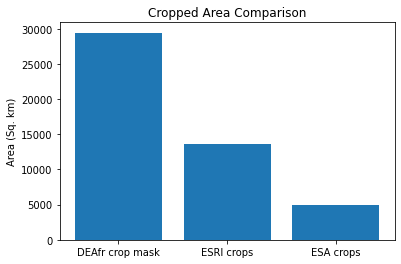

In [20]:
cm_area = cm_mask.sum().data * area_per_pixel
esri_area = esri_crops.sum().data * area_per_pixel
esa_area = esa_crops.sum().data * area_per_pixel

label = ['DEAfr crop mask', 'ESRI crops', 'ESA crops']
plt.bar(label, [cm_area,esri_area,esa_area])
plt.ylabel("Area (Sq. km)")
plt.title('Cropped Area Comparison');

## Regional crop mask boundaries

As we saw in the datasets table, the `crop_mask` is comprised of numerous regional products stitched together. We can load and use the continental `crop_mask` product for most applications. However, we may observe some unusual artefacts at the boundaries of regional crop masks which are worth being aware of. We will investigate this below.

First, we will define and inspect an area on the borders of Uganda, Rwanda, and DR Congo. This also forms the border the `crop_mask_central` and `crop_mask_eastern`. We can inspect the extent of each regional product on the [Digital Earth Africa Maps Platform](https://maps.digitalearth.africa/).

In [21]:
lat, lon = -0.83, 29.58

buffer = 1.0

resolution=(-60, 60) #resample to load larger area

#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

In [22]:
display_map(lon_range, lat_range)

In [23]:
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution':resolution
}

### Load regional crop masks

Below, we load the continental product in addtion to both the central and eastern crop masks. We do this by using the `region` argument in `dc.load`.

In [24]:
cm = dc.load(product='crop_mask',
             measurements=['mask'], 
             time='2019',
             **query).squeeze()

cm_east = dc.load(
             product='crop_mask',
             region='eastern',
             measurements=['mask'], 
             time='2019',
             **query).squeeze()

cm_central = dc.load(
             product='crop_mask',
             region='central',
             measurements=['mask'], 
             time='2019',
             **query).squeeze()

### Plot regional products

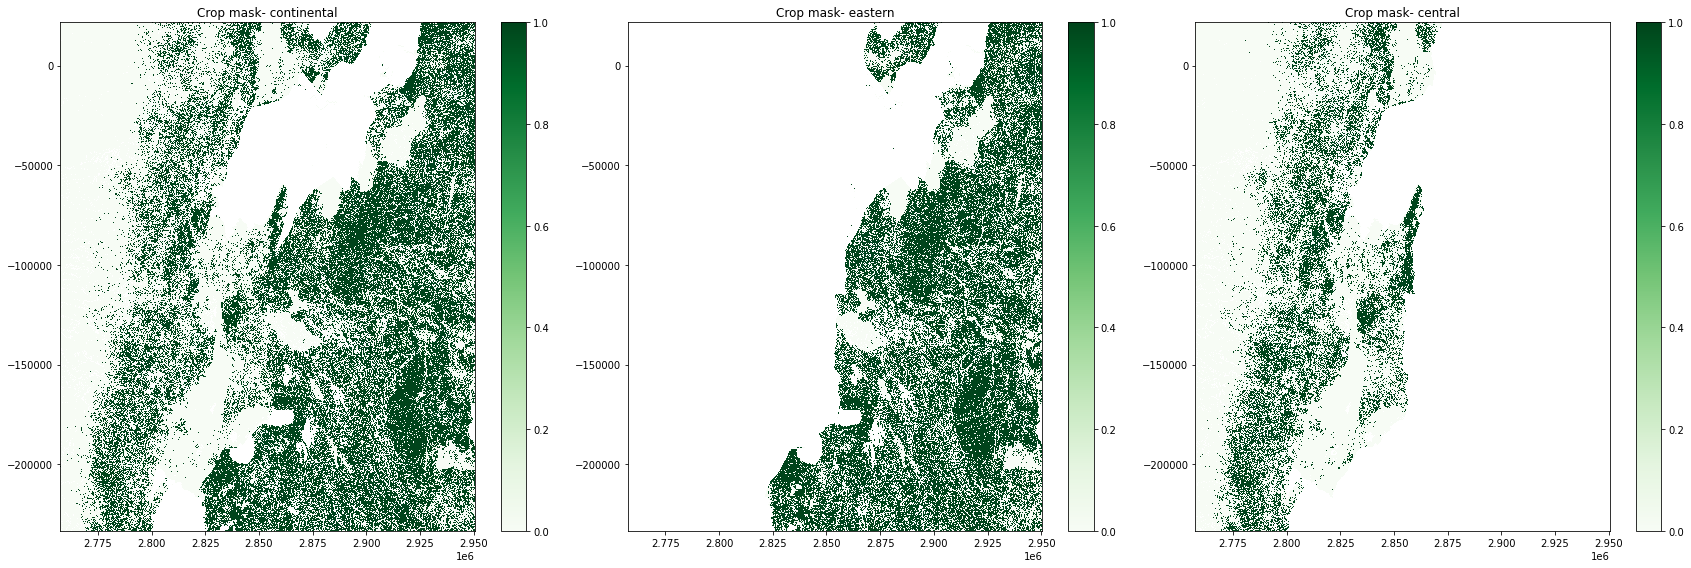

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
cm.mask.where(cm.mask<255).plot(ax=axes[0], # we filter to <255 to omit missing data
                   cmap='Greens', 
                   add_labels=False)

cm_east.mask.where(cm_east.mask<255).plot(ax=axes[1], 
                   cmap='Greens', 
                   add_labels=False)

cm_central.mask.where(cm_central.mask<255).plot(ax=axes[2], 
                   cmap='Greens', 
                   add_labels=False)

axes[0].set_title('Crop mask- continental')
axes[1].set_title('Crop mask- eastern')
axes[2].set_title('Crop mask- central');

plt.tight_layout();

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [26]:
print(datacube.__version__)

1.8.7


**Last Tested:**

In [27]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-10-24'